In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats

### Введение в задачи классификации

Классификация - это модели, в которых предсказывается как правило бинарный результ (0 или 1)

In [4]:
data = sm.datasets.get_rdataset("Affairs", 'AER').data
data.head()

,affairs,gender,age,yearsmarried,children,religiousness,education,occupation,rating
rownames,,,,,,,,,
4,0,male,37.0,10.00,no,3,18,7,4
5,0,female,27.0,4.00,no,4,14,6,4
11,0,female,32.0,15.00,yes,1,12,1,4
16,0,male,57.0,15.00,yes,5,18,6,5
23,0,male,22.0,0.75,no,2,17,6,3


In [13]:
data.shape

(601, 10)

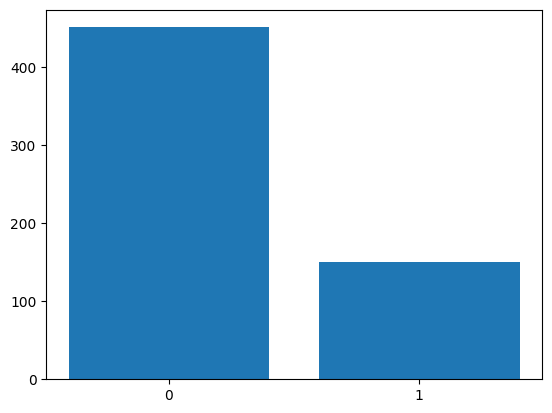

In [5]:
data['target'] = np.where(data['affairs'] > 0, 1, 0)

target_distr = data['target'].value_counts().reset_index()
target_distr['target'] = target_distr['target'].astype(str)
plt.bar(data = target_distr, x = 'target', height = 'count')
plt.show()

Мы пытаемся на основе данных о человеке предсказать, вступит ли он в сторонние "интрижки"

In [6]:
data['education'].corr(data['yearsmarried'])

np.float64(0.040002716097582124)

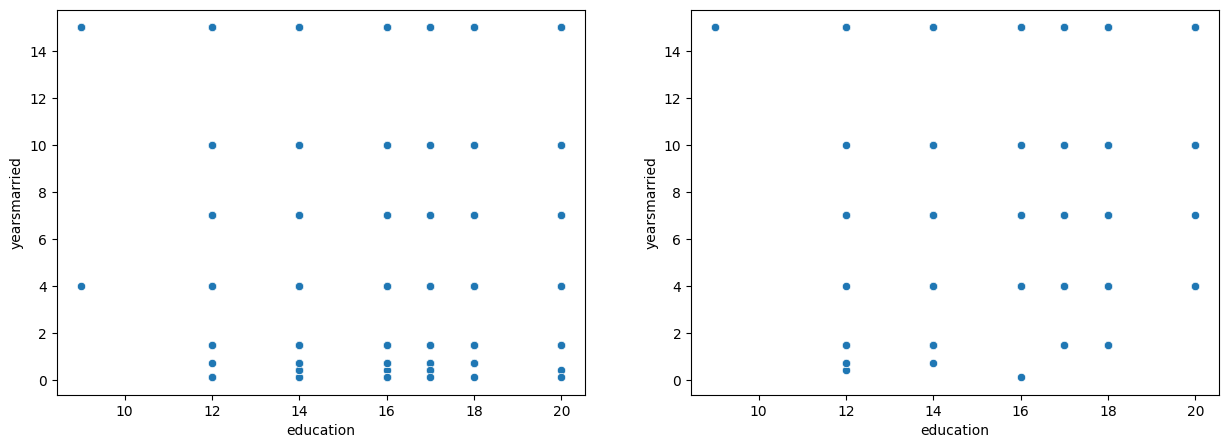

In [7]:
fig, ax = plt.subplots(1,2, figsize = (15,5))
sns.scatterplot(data = data[data['target']==0], x = 'education', y = 'yearsmarried', ax = ax[0])
sns.scatterplot(data = data[data['target']==1], x = 'education', y = 'yearsmarried', ax = ax[1])
plt.show()

### Создаем матрицу переменных-предикторов (фичей) и вектор целевой переменной (таргет)

In [8]:
X = data[['yearsmarried', 'education']].values
y = data['target'].values

In [9]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors = 3)
neigh.fit(X, y)

KNeighborsClassifier(n_neighbors=3)

In [33]:
feats = np.array([[13, 10]])
neigh.predict_proba(feats)

array([[0.66666667, 0.33333333]])

### Разделяем данные на две части: обучающая и тестовая

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

### Обучаем модель на обучающей части данных

In [19]:
neigh = KNeighborsClassifier(n_neighbors = 3)
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

### Предсказываем для тестовой части значение целевой переменной

In [20]:
y_pred = neigh.predict(X_test)

### Сравниваем предсказанные значения с реальными значениями

In [25]:
np.sum(y_test)

np.int64(49)

In [26]:
np.sum(y_pred)

np.int64(28)

In [29]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_test, y_pred), index = ['True 0', 'True 1'], columns = ['Pred 0', 'Pred 1'])

,Pred 0,Pred 1
True 0,127,23
True 1,44,5


In [32]:
from sklearn.metrics import precision_score, recall_score
print('Precision', precision_score(y_test, y_pred))
print('Recall', recall_score(y_test, y_pred))

Precision 0.17857142857142858
Recall 0.10204081632653061


Качество модели - низкое. Процент тех, кого модель корректно обозначает как неверных, составялет 17,85%, а процент реальных изменщиков, которых модель способна поймать - 10,2%

### Повышаем качество модели

#### 1) Подобрать значение гиперпараметра

In [37]:
for i in range(3, 13, 2):
    neigh = KNeighborsClassifier(n_neighbors = i)
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)
    print('Neigbors:', i, 
          'Precision:', np.round(precision_score(y_test, y_pred),3), 
          'Recall', np.round(recall_score(y_test, y_pred),3)
         )

Neigbors: 3 Precision: 0.179 Recall 0.102
Neigbors: 5 Precision: 0.179 Recall 0.102
Neigbors: 7 Precision: 0.176 Recall 0.061
Neigbors: 9 Precision: 0.222 Recall 0.041
Neigbors: 11 Precision: 0.222 Recall 0.041


#### 2) Использовать все переменные в модели

##### a) Переменные нужно грамотно подготовить

In [38]:
data

,affairs,gender,age,yearsmarried,children,religiousness,education,occupation,rating,target
rownames,,,,,,,,,,
4,0,male,37.0,10.00,no,3,18,7,4,0
5,0,female,27.0,4.00,no,4,14,6,4,0
11,0,female,32.0,15.00,yes,1,12,1,4,0
16,0,male,57.0,15.00,yes,5,18,6,5,0
23,0,male,22.0,0.75,no,2,17,6,3,0
...,...,...,...,...,...,...,...,...,...,...
1938,1,male,22.0,1.50,yes,1,12,2,5,1
1941,7,female,32.0,10.00,yes,2,18,5,4,1
1954,2,male,32.0,10.00,yes,2,17,6,5,1


In [52]:
cat_vars = ['gender', 'children', 'religiousness', 'occupation', 'rating']
num_vars = ['age', 'yearsmarried', 'education']
target_var = ['target']

In [43]:
data[cat_vars] = data[cat_vars].astype(str)

##### б) Переводим категориальные переменные в числовой формат

In [47]:
X = pd.get_dummies(data[cat_vars], drop_first = True, dtype = int)
X.head()

,gender_male,children_yes,religiousness_2,religiousness_3,religiousness_4,religiousness_5,occupation_2,occupation_3,occupation_4,occupation_5,occupation_6,occupation_7,rating_2,rating_3,rating_4,rating_5
rownames,,,,,,,,,,,,,,,,
4,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
5,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0
11,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
16,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1
23,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0


##### в) Нормализуем количественные переменные (в шкалу от 0 до 1)

In [53]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(data[num_vars])

MinMaxScaler()

In [ ]:
(data['age'] - data['age'].min()) / (data['age'].max() - data['age'].min())

In [55]:
data[num_vars]

,age,yearsmarried,education
rownames,,,
4,37.0,10.00,18
5,27.0,4.00,14
11,32.0,15.00,12
16,57.0,15.00,18
23,22.0,0.75,17
...,...,...,...
1938,22.0,1.50,12
1941,32.0,10.00,18
1954,32.0,10.00,17


In [54]:
scaler.transform(data[num_vars])

array([[0.49367089, 0.66386555, 0.81818182],
       [0.24050633, 0.2605042 , 0.45454545],
       [0.36708861, 1.        , 0.27272727],
       ...,
       [0.36708861, 0.66386555, 0.72727273],
       [0.11392405, 0.46218487, 0.81818182],
       [0.36708861, 1.        , 0.45454545]])

In [57]:
X[num_vars] = scaler.transform(data[num_vars])

In [59]:
X.head()

,gender_male,children_yes,religiousness_2,religiousness_3,religiousness_4,religiousness_5,occupation_2,occupation_3,occupation_4,occupation_5,occupation_6,occupation_7,rating_2,rating_3,rating_4,rating_5,age,yearsmarried,education
rownames,,,,,,,,,,,,,,,,,,,
4,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0.493671,0.663866,0.818182
5,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0.240506,0.260504,0.454545
11,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.367089,1.000000,0.272727
16,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,1.000000,0.818182
23,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0.113924,0.042017,0.727273


##### г) Обучаем модель на всех переменных

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [63]:
neigh = KNeighborsClassifier(n_neighbors = 3)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
print(
    'Precision:', np.round(precision_score(y_test, y_pred),3), 
    'Recall', np.round(recall_score(y_test, y_pred),3)
)

Precision: 0.325 Recall 0.265


In [62]:
for i in range(3, 13, 2):
    neigh = KNeighborsClassifier(n_neighbors = i)
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)
    print('Neigbors:', i, 
          'Precision:', np.round(precision_score(y_test, y_pred),3), 
          'Recall', np.round(recall_score(y_test, y_pred),3)
         )

Neigbors: 3 Precision: 0.325 Recall 0.265
Neigbors: 5 Precision: 0.419 Recall 0.265
Neigbors: 7 Precision: 0.385 Recall 0.204
Neigbors: 9 Precision: 0.476 Recall 0.204
Neigbors: 11 Precision: 0.45 Recall 0.184


### Пробуем другие модели классификации

#### SVM

In [64]:
from sklearn.svm import SVC
svc_clf = SVC()
svc_clf.fit(X_train, y_train)
y_pred = svc_clf.predict(X_test)
print(
    'Precision:', np.round(precision_score(y_test, y_pred),3), 
    'Recall', np.round(recall_score(y_test, y_pred),3)
)

Precision: 0.5 Recall 0.102


#### Decision tree

In [65]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)
y_pred = tree_clf.predict(X_test)
print(
    'Precision:', np.round(precision_score(y_test, y_pred),3), 
    'Recall', np.round(recall_score(y_test, y_pred),3)
)

Precision: 0.254 Recall 0.306


#### Benchmark - модель случайного предсказания

In [68]:
prob = np.mean(y_test)
print(prob)

0.24623115577889448


In [70]:
from scipy.stats import bernoulli
y_pred = bernoulli.rvs(prob, size = len(y_test))
print(
    'Precision:', np.round(precision_score(y_test, y_pred),3), 
    'Recall', np.round(recall_score(y_test, y_pred),3)
)

Precision: 0.294 Recall 0.306


#### Random Forest

In [76]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(max_depth=20, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
print(
    'Precision:', np.round(precision_score(y_test, y_pred),3), 
    'Recall', np.round(recall_score(y_test, y_pred),3)
)

Precision: 0.4 Recall 0.204


In [80]:
for i in range(1, 30, 2):
    rf_clf = RandomForestClassifier(max_depth=i, random_state=42)
    rf_clf.fit(X_train, y_train)
    y_pred = rf_clf.predict(X_test)
    print('Depth:', i, 
          'Precision:', np.round(precision_score(y_test, y_pred),3), 
          'Recall', np.round(recall_score(y_test, y_pred),3)
         )

C:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Depth: 1 Precision: 0.0 Recall 0.0
Depth: 3 Precision: 0.0 Recall 0.0
Depth: 5 Precision: 0.5 Recall 0.082
Depth: 7 Precision: 0.5 Recall 0.102
Depth: 9 Precision: 0.538 Recall 0.143
Depth: 11 Precision: 0.346 Recall 0.184
Depth: 13 Precision: 0.423 Recall 0.224
Depth: 15 Precision: 0.393 Recall 0.224
Depth: 17 Precision: 0.4 Recall 0.204
Depth: 19 Precision: 0.385 Recall 0.204
Depth: 21 Precision: 0.4 Recall 0.204
Depth: 23 Precision: 0.4 Recall 0.204
Depth: 25 Precision: 0.4 Recall 0.204
Depth: 27 Precision: 0.4 Recall 0.204
Depth: 29 Precision: 0.4 Recall 0.204
